In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.display import display
import collections

from qbstyles import mpl_style

mpl_style(dark=False)

import gym
from gym.spaces import Box

from ax import optimize

from scipy.optimize import minimize

import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import gym

import re
import ast
import time

# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : cpu


In [2]:
df = pd.read_csv('D:\\supply_chin_inventory_management\\data\\kaggle_multi_item_data.csv')
df['demand'] = df['demand'].apply(ast.literal_eval)
print(df.shape)
df.head()

(261, 6)


,year,week,sales_1,sales_2,cum_week,demand
0,2013,1,802,2067,1,"[802, 2067]"
1,2013,2,863,2350,2,"[863, 2350]"
2,2013,3,865,2427,3,"[865, 2427]"
3,2013,4,799,2329,4,"[799, 2329]"
4,2013,5,954,2414,5,"[954, 2414]"


In [3]:
res_path = "D:\\supply_chin_inventory_management\\results\\exp38"
os.makedirs(res_path, exist_ok=True)
cp_path = res_path + "\\cp_dqn"
os.makedirs(cp_path, exist_ok=True)
log_path = res_path + "\\log"
os.makedirs(log_path, exist_ok=True)


log_interval = 5000
cp_interval = 5000
print_interval = 5000

In [4]:
####### initialize environment hyperparameters ######

has_continuous_action_space = True  # continuous action space; else discrete

max_ep_len = 26                   # max timesteps in one episode
max_training_timesteps = int(5e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 10        # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2           # log avg reward in the interval (in num timesteps)

action_std = 1.0             # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2e4)  # action_std decay frequency (in num timesteps)


################ PPO hyperparameters ################

update_timestep = max_ep_len * 8      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2             # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

In [5]:
# us = up stream, ds = down stream
T = 26
n_ds = 1 # number of downstreams
n_items = 2
v = 10000 # Capacitiy list [us, ds]
storage_capacity = np.array([100000, 100000])

init_stock = np.array([2000, 5000]) # Initial stock item1, item2

demand_history_len = 4

price_1 = 100
cost_1 = 40

price_2 = 30
cost_2 = 10

price = np.array([100, 30])
cost = np.array([40, 10])

storage_costs = np.array([6, 3])  #[us, ds]
truck_trans_cost = 400

a = 50 # 'a' number of item_1 can fill the truck
b = 150 # 'b' number of item_2 can fill the truck

In [6]:
df[['sales_1', 'sales_2']].describe()

,sales_1,sales_2
count,261.000000,261.000000
mean,1537.869732,4097.946360
std,329.853182,850.621337
min,799.000000,2067.000000
25%,1284.000000,3419.000000
50%,1560.000000,4155.000000
75%,1779.000000,4737.000000
max,2298.000000,5920.000000


In [7]:
global m_item1
m_item1=1537
global sd_item1
sd_item1=350
global m_item2
m_item2=4097
global sd_item2
sd_item2=1000

In [8]:
global df_record
col_name = ["week_no", "state", "action", "demands", "revenue", "production_cost", "storage_cost", "backlog_list", "backlog_cost", "supplied", "no_of_truck", "trans_cost", "reward", "next_factory_stock"]
df_record = pd.DataFrame(columns=col_name)

df_action = pd.DataFrame(columns=['action_raw', 'action'])

global reward_list
reward_list = []
global loss_list
loss_list = []

In [9]:
class State(object):
    def __init__(self, demand_history, t=0):
        self.ds_stock = init_stock
        self.demand_history = demand_history
        self.t = t

    def to_array(self):
        return np.concatenate((self.ds_stock, np.hstack(self.demand_history), [self.t]) )

In [10]:
class select_episode(object):
    def __init__(self):
        self.df = df
    def episode_demands():
        i = np.random.randint(1,10)
        if i==1:
            episode = df.iloc[0:26]
        elif i==2:
            episode = df.iloc[26:52]
        elif i==3:
            episode = df.iloc[52:78]
        elif i==4:
            episode = df.iloc[78:104]
        elif i==5:
            episode = df.iloc[104:130]
        elif i==6:
            episode = df.iloc[130:156]
        elif i==7:
            episode = df.iloc[156:182]
        elif i==8:
            episode = df.iloc[182:208]
        elif i==9:
            episode = df.iloc[208:234]
        return episode

In [11]:
class SupplyChainEnvironment(object):
    def __init__(self):
        global df_record
        global price
        
        self.action_space = Box(low=0.0, high=18.0, shape=(n_items,), dtype=np.float32)
        self.observation_space = Box(low=-1000.0, high=1000.0, shape=(4*n_items + 3,), dtype=np.float32)

        self.backlog_lst = np.zeros(n_items)
        
    def reset(self):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append(np.zeros(n_items))
        self.t = 0
        self.episode = select_episode.episode_demands()
        self.state = self.initial_state()
        return self.state.to_array()
    
    
    def initial_state(self):
        return State(list(self.demand_history))
    
    def step(self, state, action):
        demands = np.array(self.episode.iloc[self.t]['demand'])
        
        total_revenue = sum(demands * price)
        
        # calculation of reward
        total_production_cost = sum(action * cost)
        total_storage_cost = sum([state[0],state[1]] * storage_costs)

        self.backlog_lst = -(np.minimum(([state[0],state[1]] - demands), np.repeat(0,n_items)))
        total_backlog_cost = sum(self.backlog_lst * price)
        supplied = demands - self.backlog_lst
        no_of_truck = np.ceil(action[0]/a + action[1]/b)
        total_trans_cost = no_of_truck * truck_trans_cost
        
        reward = total_revenue - total_production_cost - total_storage_cost - total_backlog_cost - total_trans_cost
        reward_list.append(reward)
        
        # calculating the next state
        self.t += 1
        self.demand_history.append(demands)
        next_state = State(list(self.demand_history), self.t)
        next_state.ds_stock = np.minimum((np.maximum(([state[0],state[1]] - supplied + action), np.repeat(0,n_items))), storage_capacity)
        next_state.demand_history = list(self.demand_history)
        next_state.t = self.t

        record_lst = [self.t, state, action, demands, total_revenue, total_production_cost, total_storage_cost, self.backlog_lst, total_backlog_cost, supplied, no_of_truck, total_trans_cost, reward, next_state.to_array()]
        df_record.loc[len(df_record)] = record_lst
        
        done = self.t == T - 1
        
        return next_state.to_array(), reward, done, {}
          

### PPO Class

In [12]:
################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self, state):
        raw_action = self.actor(state)  # Output in range [-1, 1]
        # Rescale to [action_min, action_max]
        
        return scaled_action
            
            
#     def forward(self):
#         raise NotImplementedError


    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            #print("Action_mean1", action_mean)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            #print("Cov_mat1", cov_mat)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)
        
        

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            #print("Action_mean2", action_mean)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            #print("Cov_mat2", cov_mat)
            dist = MultivariateNormal(action_mean, cov_mat)

            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            print("New_std", new_action_std)
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            print("Action_std", self.action_std)
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            loss_list.append(loss.mean().detach().numpy())
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [13]:
# ppo_agent.buffer.rewards

### Set Environment & Agent

In [14]:
########## Declare Environment & Agent ############

env = SupplyChainEnvironment()

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

### set seed
if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

########## Declare Environment & A

In [15]:
ppo_agent.buffer.clear()

### Training

In [16]:
df_action = pd.DataFrame(columns=['action_raw', 'action'])
df_record = pd.DataFrame(columns=col_name)

reward_list = []
loss_list = []

In [17]:
################  training  #####################

start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)


time_step = 0
i_episode = 0

# training loop
while time_step <= max_training_timesteps:

    state = env.reset()
    current_ep_reward = 0


    for t in range(1, max_ep_len+1):

        action_raw = ppo_agent.select_action(state)

        action = np.zeros(2)

        action[0] = action_raw[0] * sd_item1 + m_item1
        action[1] = action_raw[1] * sd_item2 + m_item2
        
        
        df_action.loc[len(df_action)] = [action_raw, action]    
        
        state, reward, done, _ = env.step(state, action)


        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_interval == 0:
            df_record.to_csv(log_path+"/record_"+str(time_step)+".csv",index=False)
            df_action.to_csv(log_path+"/action_"+str(time_step)+".csv",index=False)
            
            df_rew = pd.DataFrame({"reward": reward_list})
            df_rew.to_csv(log_path+"/rew_"+str(time_step)+".csv",index=False)
            
            df_loss = pd.DataFrame({"mean_loss": loss_list})
            df_loss.to_csv(log_path+"/loss_"+str(time_step)+".csv",index=False)
            
            df_action = pd.DataFrame(columns=['action_raw', 'action'])
            df_record = pd.DataFrame(columns=col_name)
            reward_list = []
            loss_list = []

        # Print the values
        if time_step % print_interval == 0:
            print("time", time_step)

        # save model weights
        if time_step % cp_interval == 0:
            ppo_agent.save(cp_path+"/ppo_checkpoint_"+str(time_step)+".pth")

#         break; if the episode is over
        if done:
            break

    i_episode += 1

# log_f.close()
# env.close()


# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Started training at (GMT) :  2025-01-13 11:37:35
time 5000
time 10000
time 15000
--------------------------------------------------------------------------------------------
Action_std 0.95
setting actor output action_std to :  0.95
New_std 0.95
--------------------------------------------------------------------------------------------
time 20000
time 25000
time 30000
time 35000
--------------------------------------------------------------------------------------------
Action_std 0.8999999999999999
setting actor output action_std to :  0.9
New_std 0.9
--------------------------------------------------------------------------------------------
time 40000
time 45000
time 50000
time 55000
--------------------------------------------------------------------------------------------
Action_std 0.85
setting actor output action_std to :  0.85
New_std 0.85
--------------------------------------------------------------------------------------------
time 60000
time 65000
time 70000
time 75000
-

In [18]:
df_record

,week_no,state,action,demands,revenue,production_cost,storage_cost,backlog_list,backlog_cost,supplied,no_of_truck,trans_cost,reward,next_factory_stock
0,1,"[2000.0, 5000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1144.6720118522644, 3058.9994163513184]","[954, 2766]",178380,76376.874638,27000.000000,"[-0.0, -0.0]",0.000000,"[954.0, 2766.0]",37,14800,60203.125362,"[2190.6720118522644, 5292.999416351318, 0.0, 0..."
1,2,"[2190.6720118522644, 5292.999416351318, 0.0, 0...","[1156.1115260124207, 3213.636872291565]","[972, 2657]",176910,78380.829763,29023.030320,"[-0.0, -0.0]",0.000000,"[972.0, 2657.0]",37,14800,54706.139916,"[2374.783537864685, 5849.636288642883, 0.0, 0...."
2,3,"[2374.783537864685, 5849.636288642883, 0.0, 0....","[1742.1520586013794, 3186.3489718437195]","[981, 2651]",177630,101549.572062,31797.610093,"[-0.0, -0.0]",0.000000,"[981.0, 2651.0]",37,14800,29482.817844,"[3135.9355964660645, 6384.985260486603, 0.0, 0..."
3,4,"[3135.9355964660645, 6384.985260486603, 0.0, 0...","[1223.704507470131, 3198.0658144950867]","[996, 2666]",179580,80928.838444,37970.569360,"[-0.0, -0.0]",0.000000,"[996.0, 2666.0]",37,14800,45880.592196,"[3363.6401039361954, 6917.051074981689, 954.0,..."
4,5,"[3363.6401039361954, 6917.051074981689, 954.0,...","[1255.0136978626251, 3221.09770488739]","[991, 2866]",185080,82411.524963,40932.993849,"[-0.0, -0.0]",0.000000,"[991.0, 2866.0]",38,15200,46535.481188,"[3627.6538017988205, 7272.14877986908, 972.0, ..."
5,6,"[3627.6538017988205, 7272.14877986908, 972.0, ...","[1185.18195104599, 3221.6455907821655]","[1130, 3020]",203600,79623.733950,43582.369150,"[-0.0, -0.0]",0.000000,"[1130.0, 3020.0]",42,16800,63593.896900,"[3682.8357528448105, 7473.794370651245, 981.0,..."
6,7,"[3682.8357528448105, 7473.794370651245, 981.0,...","[1222.7063204050064, 3257.4883670806885]","[1044, 3058]",196140,81483.136487,44518.397629,"[-0.0, -0.0]",0.000000,"[1044.0, 3058.0]",41,16400,53738.465884,"[3861.542073249817, 7673.282737731934, 996.0, ..."
7,8,"[3861.542073249817, 7673.282737731934, 996.0, ...","[1238.381078362465, 3305.8510394096375]","[1105, 2966]",199480,82593.753529,46189.100653,"[-0.0, -0.0]",0.000000,"[1105.0, 2966.0]",41,16400,54297.145819,"[3994.923151612282, 8013.133777141571, 991.0, ..."
8,9,"[3994.923151612282, 8013.133777141571, 991.0, ...","[1242.537298321724, 3387.875732898712]","[1194, 3148]",213840,83580.249262,48008.940241,"[-0.0, -0.0]",0.000000,"[1194.0, 3148.0]",44,17600,64650.810497,"[4043.4604499340057, 8253.009510040283, 1130.0..."
9,10,"[4043.4604499340057, 8253.009510040283, 1130.0...","[1245.5381388664246, 3319.0263481140137]","[1311, 3684]",241620,83011.789036,49019.791230,"[-0.0, -0.0]",0.000000,"[1311.0, 3684.0]",50,20000,89588.419734,"[3977.9985888004303, 7888.035858154297, 1044.0..."


### Reward Curve

In [19]:
rew_df = pd.DataFrame()
for i in range(log_interval,max_training_timesteps+1, log_interval):
    df_temp = pd.read_csv(log_path+"\\rew_"+str(i)+".csv")
    rew_df = pd.concat([rew_df, df_temp])
rew_df.reset_index(inplace=True)
rew_df['rolling_rew'] = rew_df['reward'].rolling(100).mean()
rew_df.shape

(500000, 3)

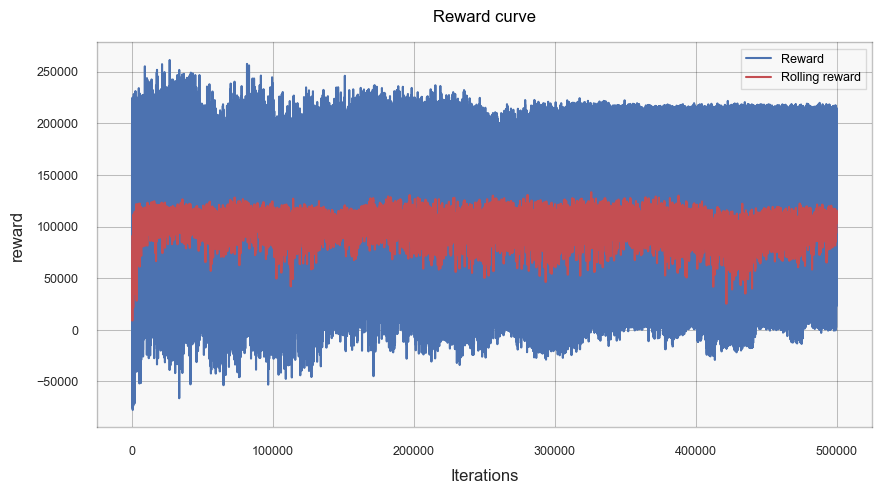

In [20]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("reward")
plt.plot(rew_df['reward'], color="b", label="Reward")
plt.plot(rew_df['rolling_rew'], color="r", label="Rolling reward")
plt.title("Reward curve")
plt.legend()
plt.show()

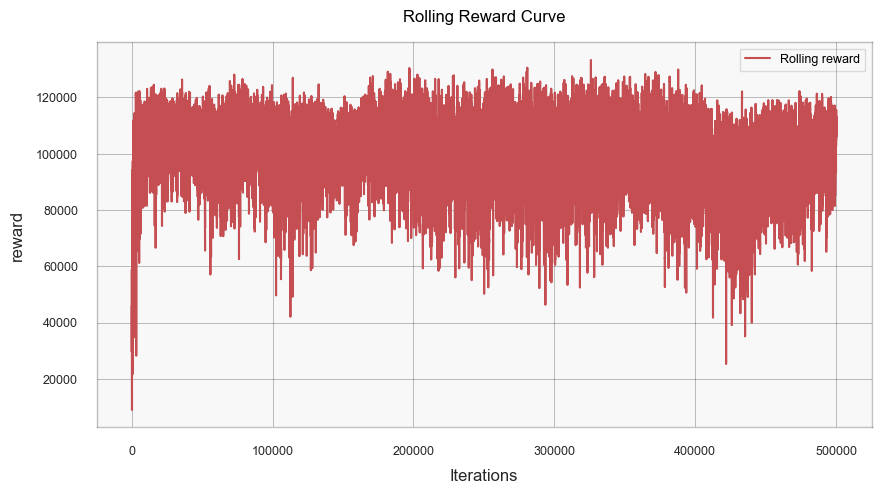

In [21]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("reward")
# plt.plot(rew_df['reward'], color="b", label="Reward")
plt.plot(rew_df['rolling_rew'], color="r", label="Rolling reward")
plt.title("Rolling Reward Curve")
plt.legend()
plt.show()

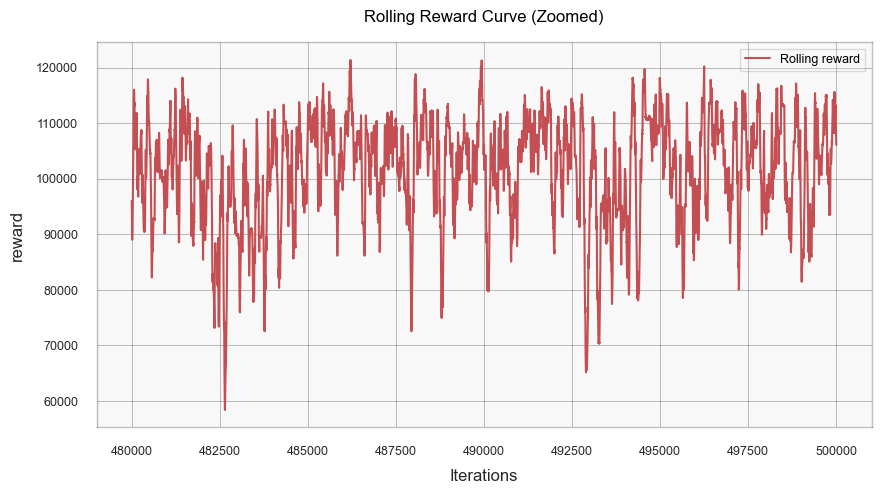

In [22]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("reward")
# plt.plot(rew_df['reward'], color="b", label="Reward")
plt.plot(rew_df['rolling_rew'][-20000:], color="r", label="Rolling reward")
plt.title("Rolling Reward Curve (Zoomed)")
plt.legend()
plt.show()

### Evaluation

#### Test Environment

In [23]:
class SupplyChainEnvironment_test(object):
    def __init__(self):
        global df_record
        global price
        
        self.action_space = Box(low=0.0, high=18.0, shape=(n_items,), dtype=np.float32)
        self.observation_space = Box(low=-1000.0, high=1000.0, shape=(4*n_items + 3,), dtype=np.float32)

        self.backlog_lst = np.zeros(n_items)
        
    def reset(self):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append(np.zeros(n_items))
        self.t = 0
        self.episode = episode = df.iloc[234:260]
        self.state = self.initial_state()
        return self.state.to_array()
    
    
    def initial_state(self):
        return State(list(self.demand_history))
    
    def step(self, state, action):
        demands = np.array(self.episode.iloc[self.t]['demand'])
        
        total_revenue = sum(demands * price)
        
        # calculation of reward
        total_production_cost = sum(action * cost)
        total_storage_cost = sum([state[0],state[1]] * storage_costs)

        self.backlog_lst = -(np.minimum(([state[0],state[1]] - demands), np.repeat(0,n_items)))
        total_backlog_cost = sum(self.backlog_lst * price)
        supplied = demands - self.backlog_lst
        no_of_truck = np.ceil(action[0]/a + action[1]/b)
        total_trans_cost = no_of_truck * truck_trans_cost
        
        reward = total_revenue - total_production_cost - total_storage_cost - total_backlog_cost - total_trans_cost
        reward_list.append(reward)
        
        # calculating the next state
        self.t += 1
        self.demand_history.append(demands)
        next_state = State(list(self.demand_history), self.t)
        next_state.ds_stock = np.minimum((np.maximum(([state[0],state[1]] - supplied + action), np.repeat(0,n_items))), storage_capacity)
        next_state.demand_history = list(self.demand_history)
        next_state.t = self.t

#         record_lst = [self.t, state, action, demands, total_revenue, total_production_cost, total_storage_cost, self.backlog_lst, total_backlog_cost, supplied, no_of_truck, total_trans_cost, reward, next_state.to_array()]
#         df_record.loc[len(df_record)] = record_lst
        
        done = self.t == T - 1
        
        return next_state.to_array(), reward, done, {}
          

In [24]:
env = SupplyChainEnvironment_test()

In [25]:
def simulate_episode_with_q(env: SupplyChainEnvironment_test, ppo_agent: ppo_agent) -> list:
    """Simulates a single episode using the Q-network."""
    state = env.reset()
    transitions = []

    for t in range(max_ep_len):
#         state_array = state.to_array()
#         action_values = q_network.predict(state_array)
#         action = select_action_from_q(action_values)
        action = ppo_agent.select_action(state)
        action[0] = action[0] * sd_item1 + m_item1
        action[1] = action[1] * sd_item2 + m_item2
        

        next_state, reward, _, _ = env.step(action)
        transitions.append([state, action, reward])
        state = next_state

    return transitions

In [27]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions_rl(transitions):
    st_lst = []
    act_lst = []
    rw_lst = []
    for i in range(len(transitions)):
        st_lst.append(transitions[i][0])
        act_lst.append(transitions[i][1])    
        rw_lst.append(transitions[i][2])    
    
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2
    print(f"Return is {sum(rw_lst)}")

#     fig = plt.figure(figsize=(8, 12))
#     prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
#     plt.plot(range(max_ep_len), list(map(lambda s: s[0], st_lst)), c='purple', alpha=0.5)

    for w in range(2):
        prepare_metric_plot(plots_n, 1+w, f"Stock,\n WH {w+1}")
        plt.plot(range(max_ep_len), list(map(lambda s: s[w+1], st_lst)), c='purple', alpha=0.5)

#     prepare_metric_plot(plots_n, 5, "Production")
#     plt.plot(range(max_ep_len), list(map(lambda a: a[0], act_lst)), c='blue', alpha=0.5)

    for w in range(2):
        prepare_metric_plot(plots_n, 9+w, f"Shipment,\n WH {w+1}")
        plt.plot(range(max_ep_len), list(map(lambda a: a[w+1], act_lst)), c='blue', alpha=0.5)

    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(max_ep_len), rw_lst, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
#     plt.ylim(0, 10000)
    plt.plot(range(max_ep_len), np.cumsum(rw_lst), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

#### Evaluation for 100 times

Episode 1 Return: 3275610.096435547
Episode 2 Return: 3251528.2678222656
Episode 3 Return: 3239502.1213378906
Episode 4 Return: 3227695.1528320312
Episode 5 Return: 3256722.1254882812
Episode 6 Return: 3258861.287109375
Episode 7 Return: 3249974.4970703125
Episode 8 Return: 3254589.8627929688
Episode 9 Return: 3233573.8596191406
Episode 10 Return: 3238817.272705078
Episode 11 Return: 3247120.1616210938
Episode 12 Return: 3248044.3203125
Episode 13 Return: 3239914.0373535156
Episode 14 Return: 3259263.4470214844
Episode 15 Return: 3234669.1232910156
Episode 16 Return: 3224469.8330078125
Episode 17 Return: 3250005.8676757812
Episode 18 Return: 3260868.4067382812
Episode 19 Return: 3269716.8754882812
Episode 20 Return: 3236455.1032714844
Episode 21 Return: 3270377.1645507812
Episode 22 Return: 3240245.8103027344
Episode 23 Return: 3242651.1884765625
Episode 24 Return: 3257765.5993652344
Episode 25 Return: 3281937.408203125
Episode 26 Return: 3260570.627685547
Episode 27 Return: 3263116.41

C:\Users\ajit.mishra\AppData\Local\Temp\ipykernel_23064\3413665489.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plots_n, 1, n)


IndexError: index 2 is out of bounds for axis 0 with size 2

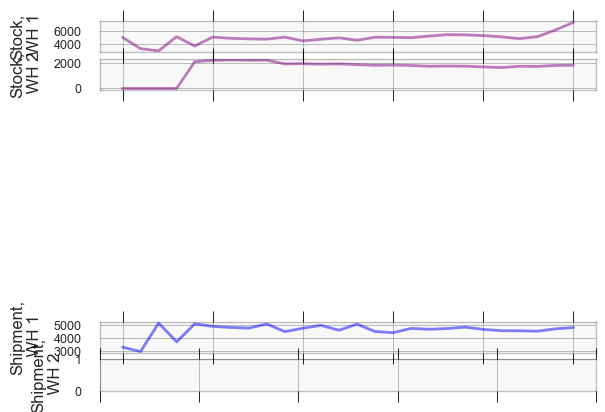

In [28]:
from matplotlib import rcParams

# Initialize variables
best_return = float('-inf')
best_transitions = None
returns_list_rl = []

# Run the simulation for 20 episodes
for episode in range(100):
    env = SupplyChainEnvironment_test()
    state = env.reset()
    transitions_rl = []

    for t in range(max_ep_len):
#         state_array = state.to_array()
#         action_values = q_network.predict(state_array)
#         action = select_action_from_q(action_values)
        action = ppo_agent.select_action(state)
        action[0] = action[0] * sd_item1 + m_item1
        action[1] = action[1] * sd_item2 + m_item2


        next_state, reward, _, _ = env.step(state, action)
        transitions_rl.append([state, action, reward])
        state = next_state
    # Calculate the return for the current episode
    episode_return = sum(transition[2] for transition in transitions_rl)
    returns_list_rl.append(episode_return)
    print(f"Episode {episode + 1} Return: {episode_return}")

    # Update the best transitions if the current return is the highest
    if episode_return > best_return:
        best_return = episode_return
        best_transitions = transitions_rl

print(f"Best Episode Return: {best_return}")

# Visualize the transitions of the best episode
if best_transitions:
    visualize_transitions_rl((best_transitions))

### Evaluation visualization

In [30]:
item1_stock_rl = [best_transitions[i][0][0] for i in range(26)]
item2_stock_rl = [best_transitions[i][0][1] for i in range(26)]
demand_item1 = [best_transitions[i][0][8] for i in range(26)]
demand_item2 = [best_transitions[i][0][9] for i in range(26)]

In [31]:
item1_supp_rl = [best_transitions[i][1][0] for i in range(26)]
item2_supp_rl = [best_transitions[i][1][1] for i in range(26)]

#### Stock

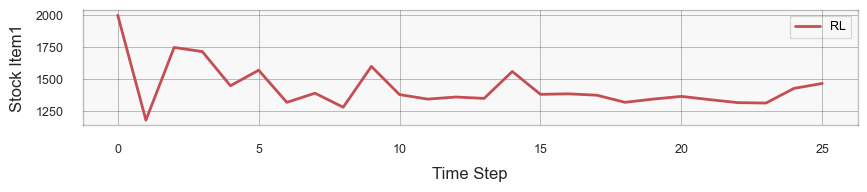

In [32]:
plt.figure(figsize=(10,1.5))
sns.lineplot(item1_stock_rl, label="RL", color="r")
# sns.lineplot(item1_stock_sq, label="SQ", color="b")
plt.xlabel("Time Step")
plt.ylabel("Stock Item1")
plt.legend()
plt.show()

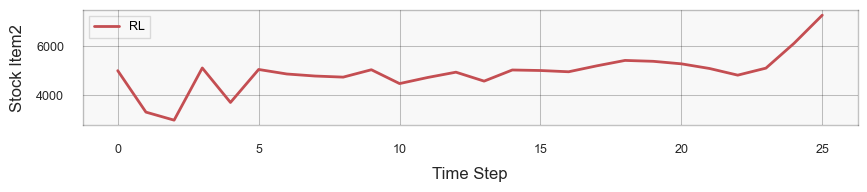

In [33]:
plt.figure(figsize=(10,1.5))
sns.lineplot(item2_stock_rl, label="RL", color="r")
# sns.lineplot(item2_stock_sq, label="SQ", color="b")
plt.xlabel("Time Step")
plt.ylabel("Stock Item2")
plt.legend()
plt.show()

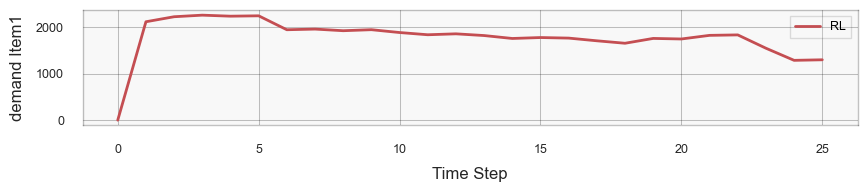

In [34]:
plt.figure(figsize=(10,1.5))
sns.lineplot(demand_item1, label="RL", color="r")
plt.xlabel("Time Step")
plt.ylabel("demand Item1")
plt.legend()
plt.show()

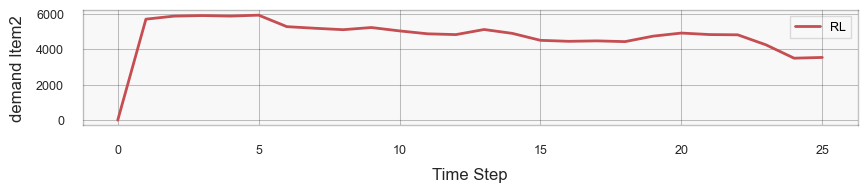

In [35]:
plt.figure(figsize=(10,1.5))
sns.lineplot(demand_item2, label="RL", color="r")
plt.xlabel("Time Step")
plt.ylabel("demand Item2")
plt.legend()
plt.show()

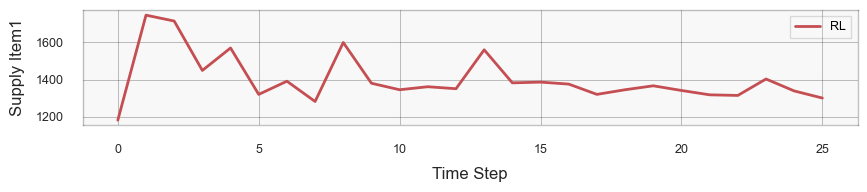

In [36]:
plt.figure(figsize=(10,1.5))
sns.lineplot(item1_supp_rl, label="RL", color="r")
# sns.lineplot(item1_supp_sq, label="SQ", color="b")
plt.xlabel("Time Step")
plt.ylabel("Supply Item1")
plt.legend()
plt.show()

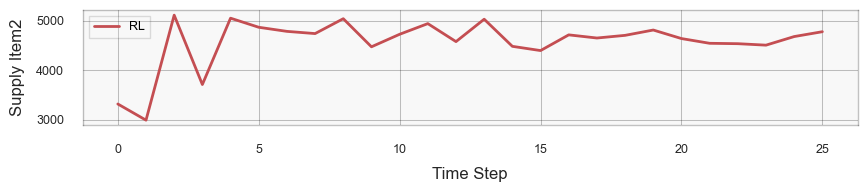

In [37]:
plt.figure(figsize=(10,1.5))
sns.lineplot(item2_supp_rl, label="RL", color="r")
# sns.lineplot(item2_supp_sq, label="SQ", color="b")
plt.xlabel("Time Step")
plt.ylabel("Supply Item2")
plt.legend()
plt.show()

In [38]:
rew_lst_rl = [best_transitions[i][2] for i in range(26)]

In [39]:
cum_rew_lst_rl = []
a=0
for i in rew_lst_rl:
    a+=i
    cum_rew_lst_rl.append(a)

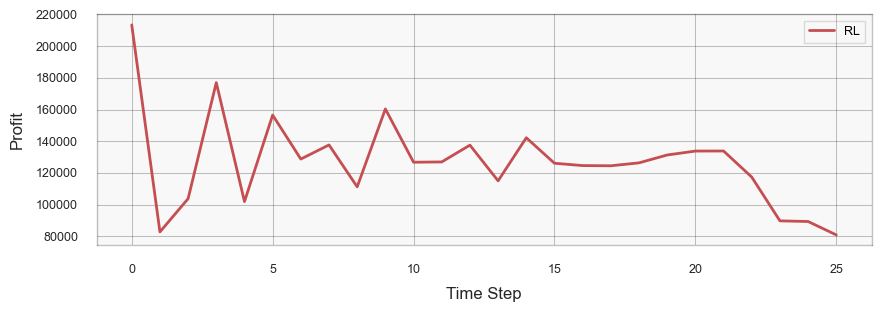

In [40]:
plt.figure(figsize=(10,3))
sns.lineplot(rew_lst_rl, label="RL", color="r")
# sns.lineplot(rew_lst_sq, label="SQ", color="b")
plt.xlabel("Time Step")
plt.ylabel("Profit")
plt.legend()
plt.show()

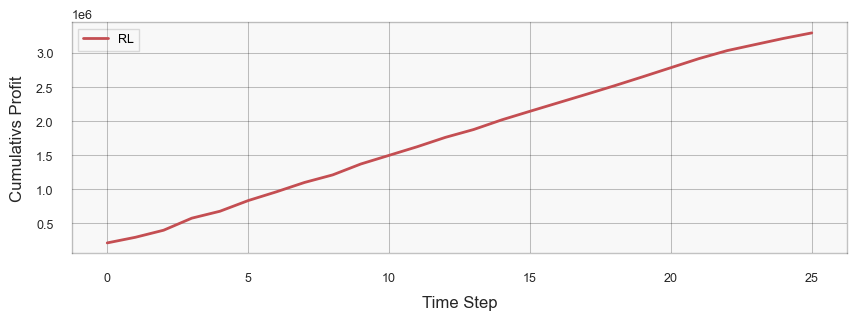

In [41]:
plt.figure(figsize=(10,3))
sns.lineplot(cum_rew_lst_rl, label="RL", color="r")
# sns.lineplot(cum_rew_lst_sq, label="SQ", color="b")
plt.xlabel("Time Step")
plt.ylabel("Cumulativs Profit")
plt.legend()
plt.show()